### Overfit 발생 모델, 훈련/검증/테스트로 데이터 구성

In [ ]:
# 보안 문제로 ipynb 파일 open시마다 실행
# from google.colab import drive
# drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

Mounted at /content/drive


In [16]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/survival' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (5, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [2]:
data = np.loadtxt('../../../data/survival/survival.csv', delimiter=",", dtype=np.float64)
# 사망자 삭제를 통한 생존자 비율 조정
# data = np.loadtxt('./Survival2.csv', delimiter=",", dtype=np.float64)
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(470, 18)


In [4]:
X = data[:, 0:17] # 0 ~ 16: 17개, 독립 변수
print(X.shape)
Y = data[:, 17]   # 17: 1개, 종속 변수, target
print(Y.shape)

(470, 17)
(470,)


In [5]:
# 생존자, 사망자
rpt = [0] * 2 # [0,0]
for row in Y:
    # print(row)
    row = int(row)
    rpt[row] = rpt[row] + 1 # row: 0 사망자 카운트, row 1: 생존자 카운트
    
print('사망자: {0:.0f}, 생존자: {1:.0f}'.format(rpt[0], rpt[1]))   

사망자: 400, 생존자: 70


In [6]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기(x_train_all), 10%: 테스트(x_test)
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                          stratify=Y,
                                                          test_size=0.1,
                                                          random_state=seed)
# Overfit
# 나머지 데이터 90%를 분할, 70%: 훈련(x_train), 30%: 검증(x_val)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.3,
                                                  random_state=seed)

print(y_val[0:100])
print(y_val.shape)

[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
(127,)


In [14]:
# 네트워크 구현
def overfit1():
    SEED = 0
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    tf.random.set_seed(SEED) # Global seed
    np.random.seed(SEED)
    random.seed(SEED)

    model = Sequential()
    model.add(Dense(128, input_dim=17, activation='relu')) # 기울기 소실 방지
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # True/False
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['accuracy'])
    model.summary()

    # patience=14: Overfit, 과대 적합, 일반화 성질 훼손
    #                       모델이 외부에서 사용시 정확도가 기대보다 떨어짐.
    # restore_best_weights=True: 학습 종료시 가장 우수한 가중치, 편향으로 저장
    es= EarlyStopping(monitor='loss', patience=14, restore_best_weights=True)

    MODEL_DIR = './model/'
    if not os.path.exists(MODEL_DIR): # 폴더가 존재하지 않으면 생성
        os.mkdir(MODEL_DIR) # 폴더 생성

    # 03d: 좌측 0 padding 정수 3자리, .4f: 실수 소수점 4자리 
    modelpath='./model/{epoch:03d}-{val_accuracy:.4f}.h5'  
    # epoch:03d: 부족한 자리를 0으로 채우는 정수 형식
    # val_accuracy:.4f: 소수이하 4째자리까지 표현 형식

    # 검증 정확도가 개선되었을 때만 학습 모델 파일로 저장
    # filepath=modelpath: 파일이 저장되는 경로와 파일명
    # monitor='val_accuracy': 검증 정확도 기준으로 판단
    # verbose=1: 기록되는 파일 정보 출력
    # save_best_only=True: 검증 정확도가 개선되면 파일로 저장
    mcp= ModelCheckpoint(filepath=modelpath,
                        monitor='val_accuracy',
                        verbose=1, save_best_only=True)

    start = time.time()
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True,
                    epochs=1000, batch_size=1, callbacks=[es, mcp])
    end=time.time()
    print('Runtime: {0:.0f} 초'.format(end-start))
    # patience=5 i5 2320: 188s, i9-10900kf: i9-11900H 54s,
    # Ryzen 7 2700X: 121s, Ryzen 5 3600: 54s
    
    return model, hist

In [19]:
model, hist = overfit1()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_15 (Dense)            (None, 128)               2304      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 15)                495       
                                                                 
 dense_19 (Dense)            (None, 1)                 16        
                                                                 
Total params: 13,151
Trainable params: 13,151
Non-trainable

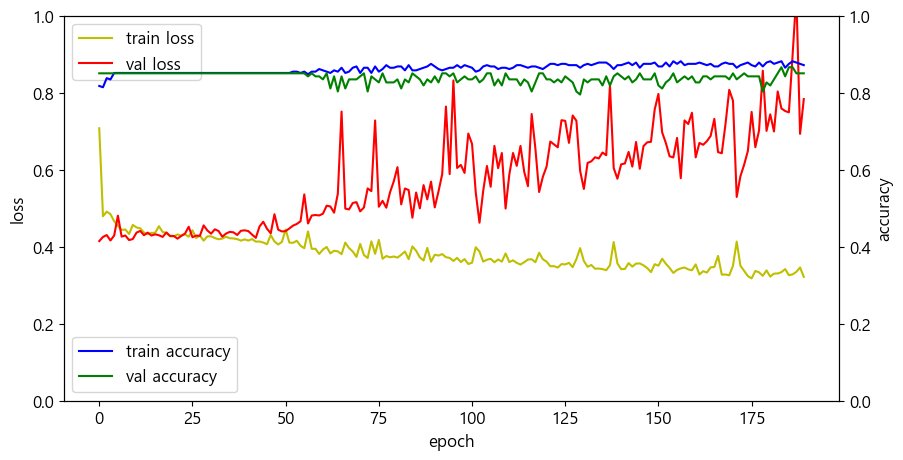

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.8353038430213928 /정확도: 78.72340679168701 %


In [23]:
# 생존자의 규칙 파악에 실패하여 생존자 예측이 1~2명 정도만 가능하다.
# 85.10638475418091 % 신뢰할 수 없다.
# 생존자의 데이터를 증가 시켜야한다.
# 사망 생존에 영향을 많이 주는 변수를 주성분 분석등을 이용하여 파악한다.
# 기존 생존자 데이터가 규칙성이 없는 경우 데이터 증폭을 위해 기존 데이터의
# 중앙값이나 평균등을 이용하여 데이터를 추가해도 정확도 개선은 어렵다.
# 재료(데이터)가 부실하면 생산 제품도 부실하다.

(47, 17)
2/2 [==============================] - 0s 0s/step
[[0]
 [0]
 [0]
 [0]
 [0]]


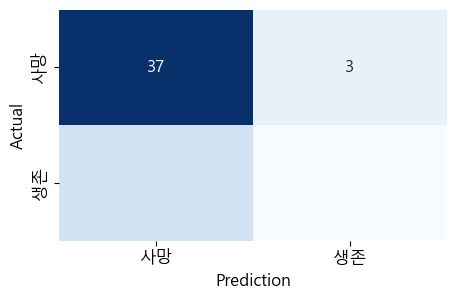

[[37  3]
 [ 7  0]]


In [24]:
# 결과 - 혼동 행렬
print(x_test.shape)

# 모델 테스트, Tensorflow 2.5까지 지원
# y_test_pred = model.predict_classes(x_test)  

# 모델 테스트, Tensorflow 2.6 이상 지원
y_test_pred = (model.predict(x_test) >= 0.5).astype("int32")  # 모델 테스트,
print(y_test_pred[:5])

c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sb.heatmap(c_matrix, annot=True, 
                 xticklabels=['사망', '생존'], 
                 yticklabels=['사망', '생존'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()

print(c_matrix)

# [[40   0]
#  [ 7   0]]
# [[사망자 맞춘 갯수   사망자 틀린 갯수]
#  [생존자 틀린 갯수   생존자 맞춘갯수]]

2/2 [==============================] - 0s 2ms/step


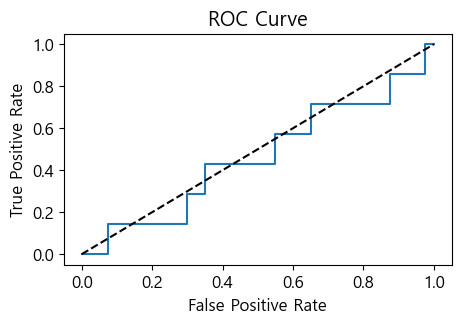

In [13]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(x_test)
# print(y_test_pred_probs)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# 과대적합, 과적합, Overfit 감소 방법
# patience 감소, 네트워크 단순화.